In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
import os
import dsc
from dsc.query_engine import Query_Processor as dscQP
from dsc import dsc_io

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)

In [2]:
def stratify_dfcol(df, colname, value):
    #return pd_utils.select_dfrows(df, [f"$({colname}) == {value}"])
    return df.loc[df[colname] == value]

def stratify_dfcols(df, condition_list):
    for (colname, value) in condition_list:
        df = stratify_dfcol(df, colname, value)
    return df

def stratify_dfcols_in_list(df, colname, values):
    return df.loc[df[colname].isin(values)]

In [3]:
dsc_output = "/gpfs/commons/groups/knowles_lab/sbanerjee/low_rank_matrix_approximation_numerical_experiments/lrma_single"
dsc_fname  = os.path.basename(os.path.normpath(dsc_output))
db = os.path.join(dsc_output, dsc_fname + ".db")
dscoutpkl = os.path.join("../dsc/results", dsc_fname + "_dscout.pkl")
dscout    = pd.read_pickle(dscoutpkl)
dscout

,DSC,simulate,simulate.n,simulate.p,simulate.k,simulate.h2,simulate.h2_shared_frac,simulate.aq,lowrankfit,matfactor,score.L_rmse,score.F_rmse,score.Z_rmse,score.L_psnr,score.F_psnr,score.Z_psnr,score.adj_MI
0,1,blockdiag,500.0,1000.0,100.0,0.6,0.6,0.6,identical,truncated_svd,0.209831,0.596624,0.014681,31.727158,23.231390,21.097395,0.984238
1,1,blockdiag,500.0,1000.0,100.0,0.6,0.6,0.6,rpca,truncated_svd,0.267870,0.725143,0.014868,29.606072,21.536928,20.987809,0.988308
2,1,blockdiag,500.0,1000.0,100.0,0.6,0.6,0.6,nnm,truncated_svd,0.242236,0.720580,0.014872,30.479771,21.591758,20.985515,0.988738
3,1,blockdiag,500.0,1000.0,100.0,0.6,0.6,0.6,nnm_sparse,truncated_svd,0.243157,0.721814,0.014869,30.446811,21.576896,20.987057,0.988308
4,1,blockdiag_p,500.0,500.0,100.0,0.6,0.6,0.6,identical,truncated_svd,0.202949,0.556797,0.019355,32.068786,23.579551,20.322871,0.988842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,1,blockdiag_h2shared,500.0,1000.0,100.0,0.6,0.8,0.6,identical,factorgo,0.575353,0.633329,0.005150,23.601932,22.533370,30.534626,-0.000653
71,1,blockdiag_h2shared,500.0,1000.0,100.0,0.6,1.0,0.6,identical,factorgo,0.586244,0.634620,0.005198,23.077079,22.720776,31.293437,0.002243
72,1,blockdiag_aq,500.0,1000.0,100.0,0.6,0.6,0.2,identical,factorgo,0.275299,0.352868,0.005203,29.119152,28.073692,30.474988,-0.001874
73,1,blockdiag_aq,500.0,1000.0,100.0,0.6,0.6,0.4,identical,factorgo,0.440020,0.510547,0.005155,25.264929,24.622444,29.981097,-0.001532


In [4]:
methods = {
    "rpca" : ["rpca", "truncated_svd"],
    "nnm"  : ["nnm", "truncated_svd"],
    "nnm_sparse" : ["nnm_sparse", "truncated_svd"],
    "truncated_svd" : ["identical", "truncated_svd"],
    "factorgo" : ["identical", "factorgo"],
}
method_labels = {
    "rpca" : "RPCA-IALM",
    "nnm" : "NN-FW",
    "nnm_sparse" : "NN-Sparse-FW",
    "truncated_svd": "tSVD",
    "factorgo": "FactorGO",
}

method_colors = {
    "rpca" : '#FF6800', # Vivid Orange
    "nnm" : '#C10020', # Vivid Red
    "nnm_sparse" : '#803E75', # Strong Purple
    "truncated_svd" : '#535154', # gray
    "factorgo" : '#A6BDD7', # Very Light Blue
}

# Base parameters
simparams = {'p': 1000, 'k': 100, 'h2': 0.6, 'h2_shared_frac': 0.6, 'aq': 0.6}
score_names = {
    'L_rmse': r"$\| L - \hat{L}\|_F$",
    'F_rmse': r"$\| F - \hat{F}\|_F$",
    'adj_MI': "Adjusted Mutual Information Score",
}

In [5]:
def get_simulation_with_variable(df, var_name, var_values):
    condition = [(f'simulate.{k}', v) for k, v in simparams.items() if k != var_name]
    df1 = stratify_dfcols(df, condition)
    df2 = stratify_dfcols_in_list(df1, f'simulate.{var_name}', var_values)
    return df2

In [6]:
def get_scores_from_dataframe(df, score_name, variable_values):
    scores = {key: list() for key in methods.keys()}
    for method, mlist in methods.items():
        mrows = stratify_dfcols(df, [('lowrankfit', mlist[0]), ('matfactor', mlist[1])])
        for value in variable_values:
            row = stratify_dfcol(mrows, f'simulate.{variable}', value)
            score = row.iloc[0][f'score.{score_name}']
            scores[method].append(score)
    return scores

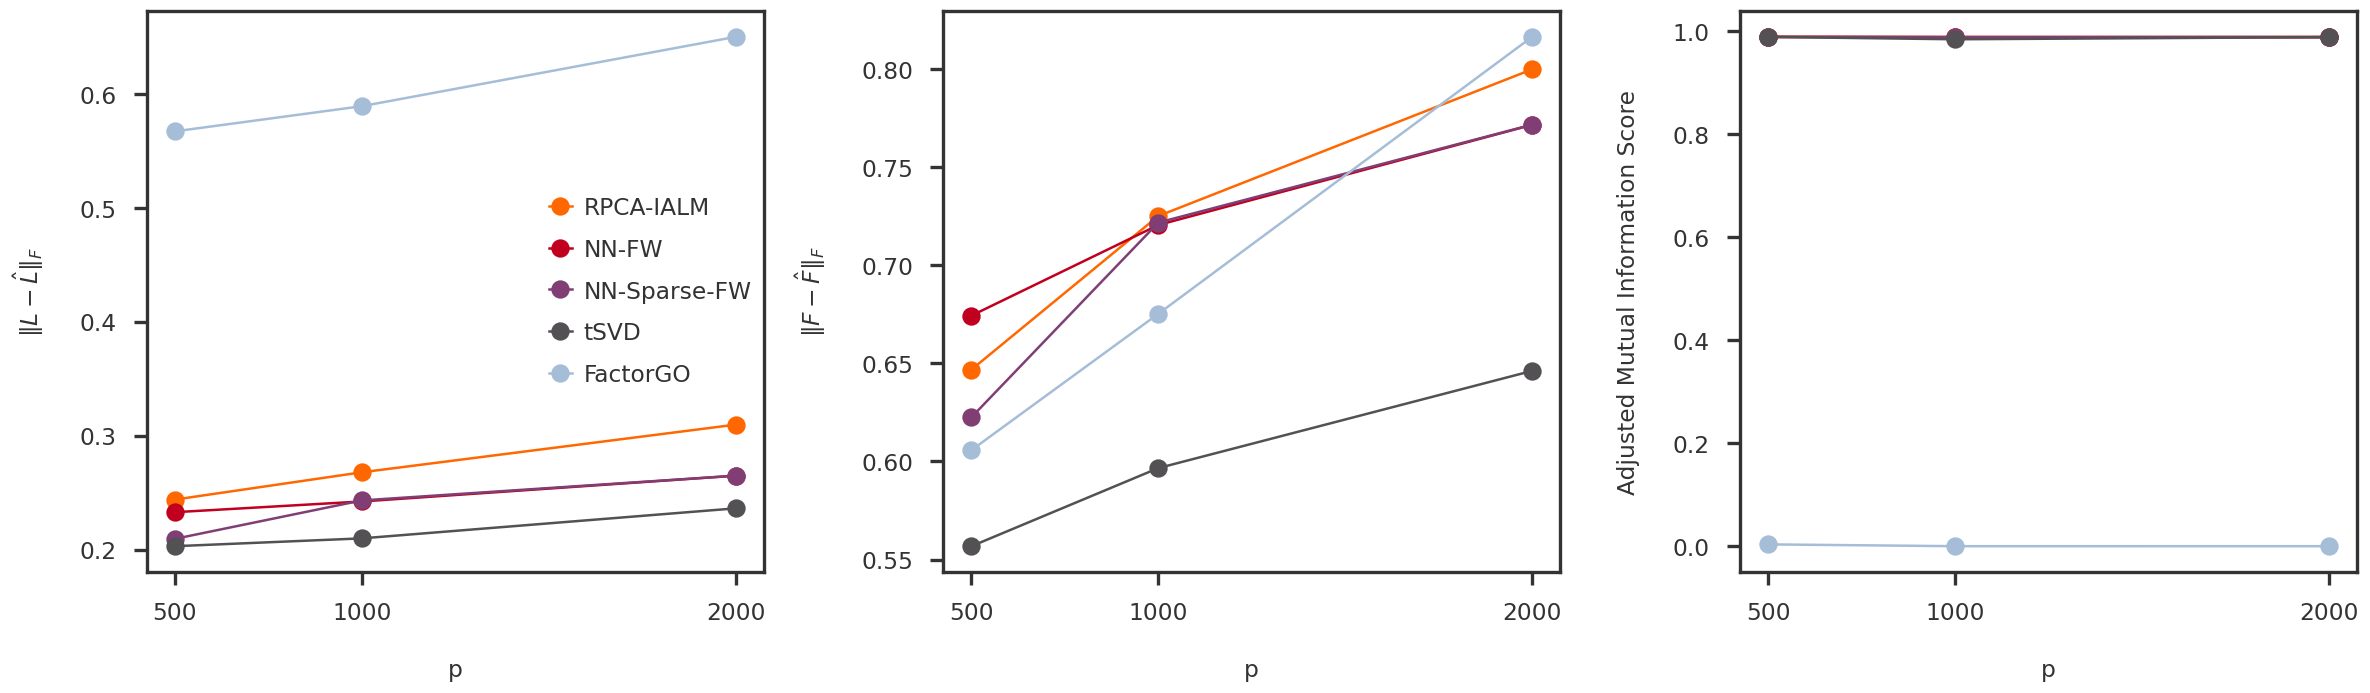

In [7]:
variable = 'p'
variable_values = [500, 1000, 2000]
df = get_simulation_with_variable(dscout, variable, variable_values)

fig = plt.figure(figsize = (20, 6))
axs = [fig.add_subplot(1,3,x+1) for x in range(3)]
for i, (score_name, score_label) in enumerate(score_names.items()):
    scores = get_scores_from_dataframe(df, score_name, variable_values)
    for mkey in methods.keys():
        axs[i].plot(variable_values, scores[mkey], 
                    marker = 'o', markersize = 10,
                    color = method_colors[mkey], label = method_labels[mkey])
    axs[i].set_xticks(variable_values)
    axs[i].set_ylabel(score_label)
    axs[i].set_xlabel(variable)
axs[0].legend()
plt.tight_layout()
plt.show()

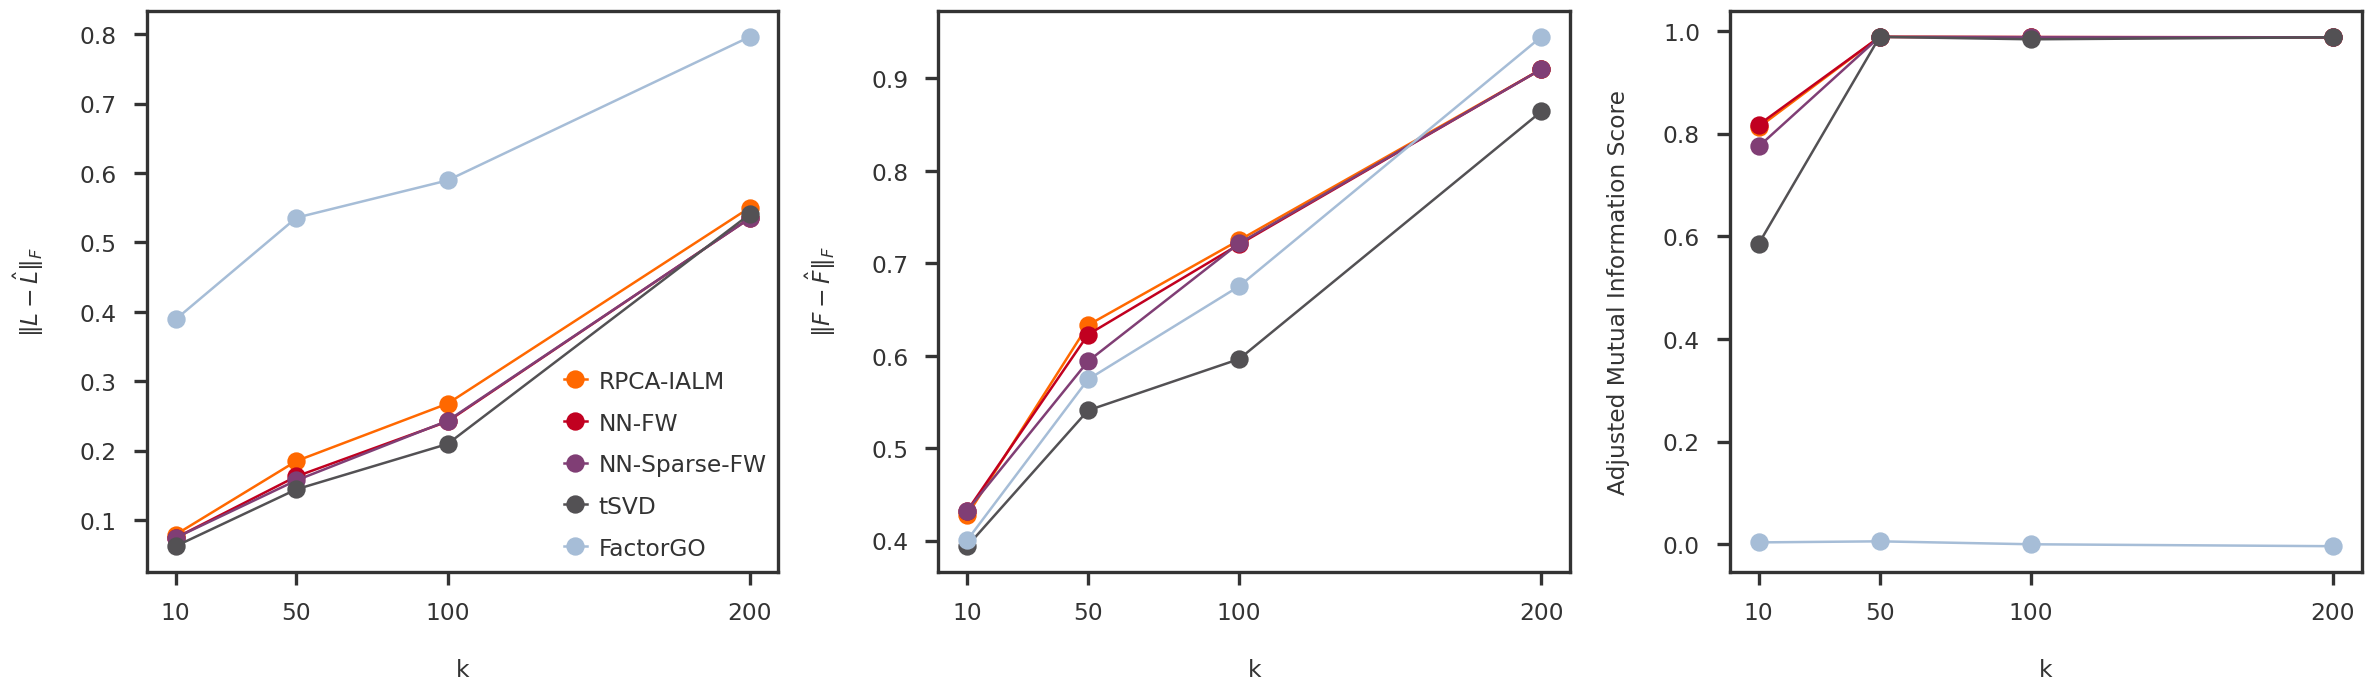

In [8]:
variable = 'k'
variable_values = [10, 50, 100, 200]
df = get_simulation_with_variable(dscout, variable, variable_values)

fig = plt.figure(figsize = (20, 6))
axs = [fig.add_subplot(1,3,x+1) for x in range(3)]
for i, (score_name, score_label) in enumerate(score_names.items()):
    scores = get_scores_from_dataframe(df, score_name, variable_values)
    for mkey in methods.keys():
        axs[i].plot(variable_values, scores[mkey], 
                    marker = 'o', markersize = 10,
                    color = method_colors[mkey], label = method_labels[mkey])
    axs[i].set_xticks(variable_values)
    axs[i].set_ylabel(score_label)
    axs[i].set_xlabel(variable)
axs[0].legend()
plt.tight_layout()
plt.show()

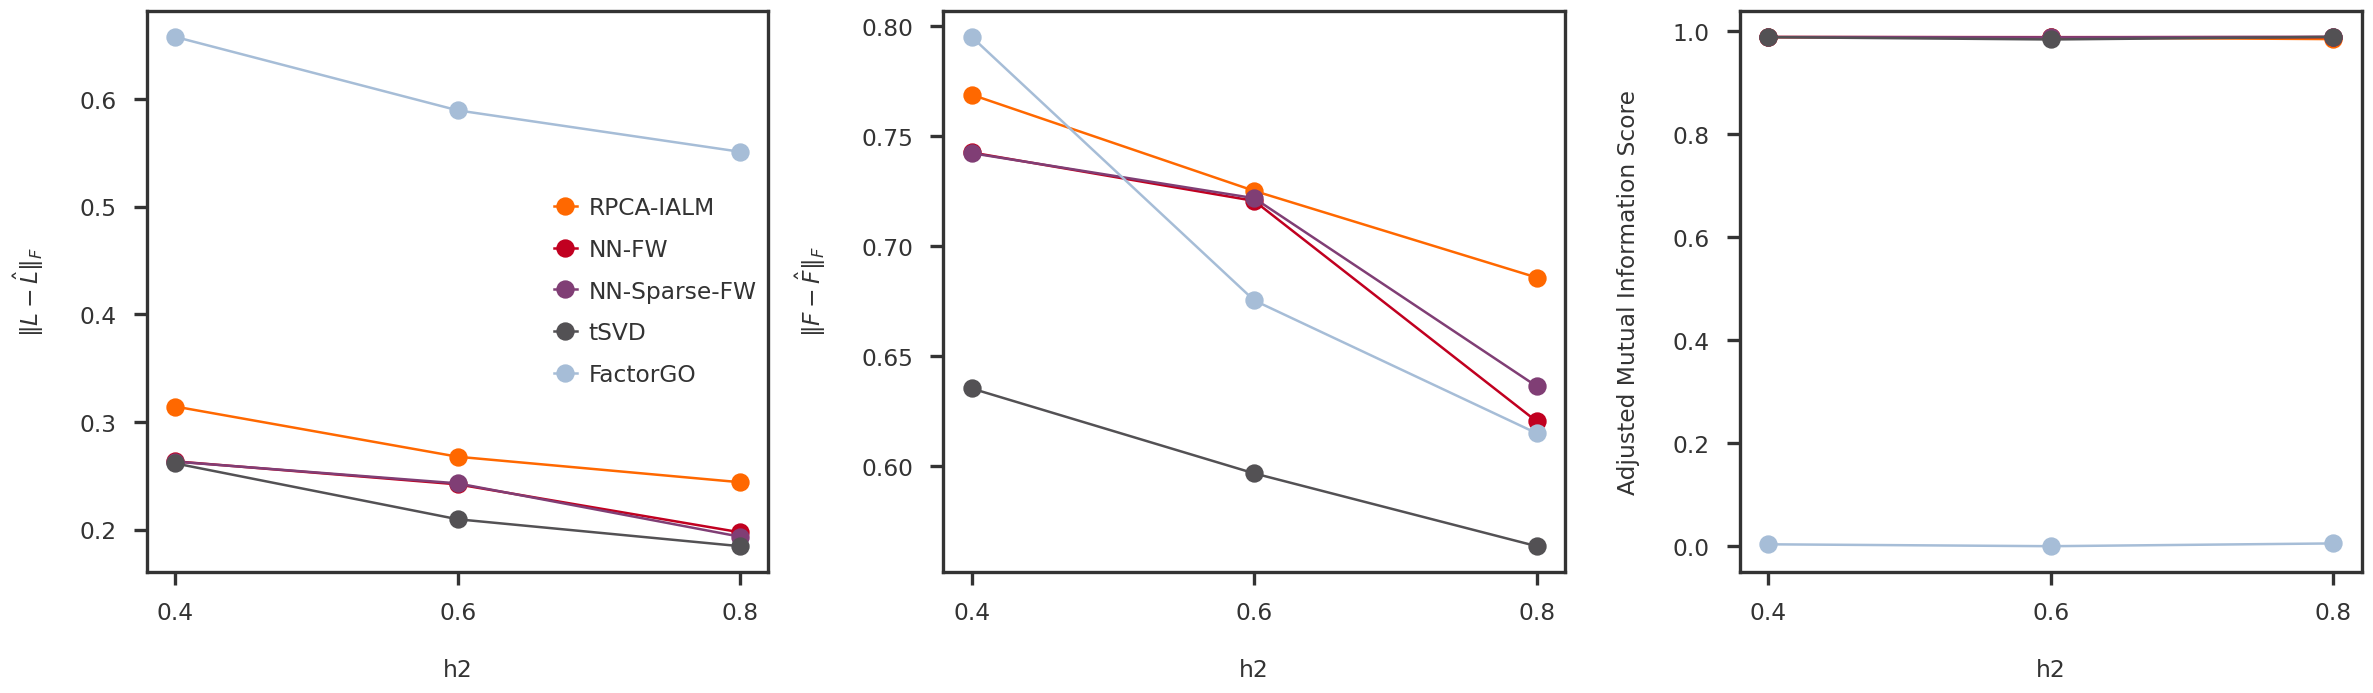

In [9]:
variable = 'h2'
variable_values = [0.4, 0.6, 0.8]
df = get_simulation_with_variable(dscout, variable, variable_values)

fig = plt.figure(figsize = (20, 6))
axs = [fig.add_subplot(1,3,x+1) for x in range(3)]
for i, (score_name, score_label) in enumerate(score_names.items()):
    scores = get_scores_from_dataframe(df, score_name, variable_values)
    for mkey in methods.keys():
        axs[i].plot(variable_values, scores[mkey], 
                    marker = 'o', markersize = 10,
                    color = method_colors[mkey], label = method_labels[mkey])
    axs[i].set_xticks(variable_values)
    axs[i].set_ylabel(score_label)
    axs[i].set_xlabel(variable)
axs[0].legend()
plt.tight_layout()
plt.show()

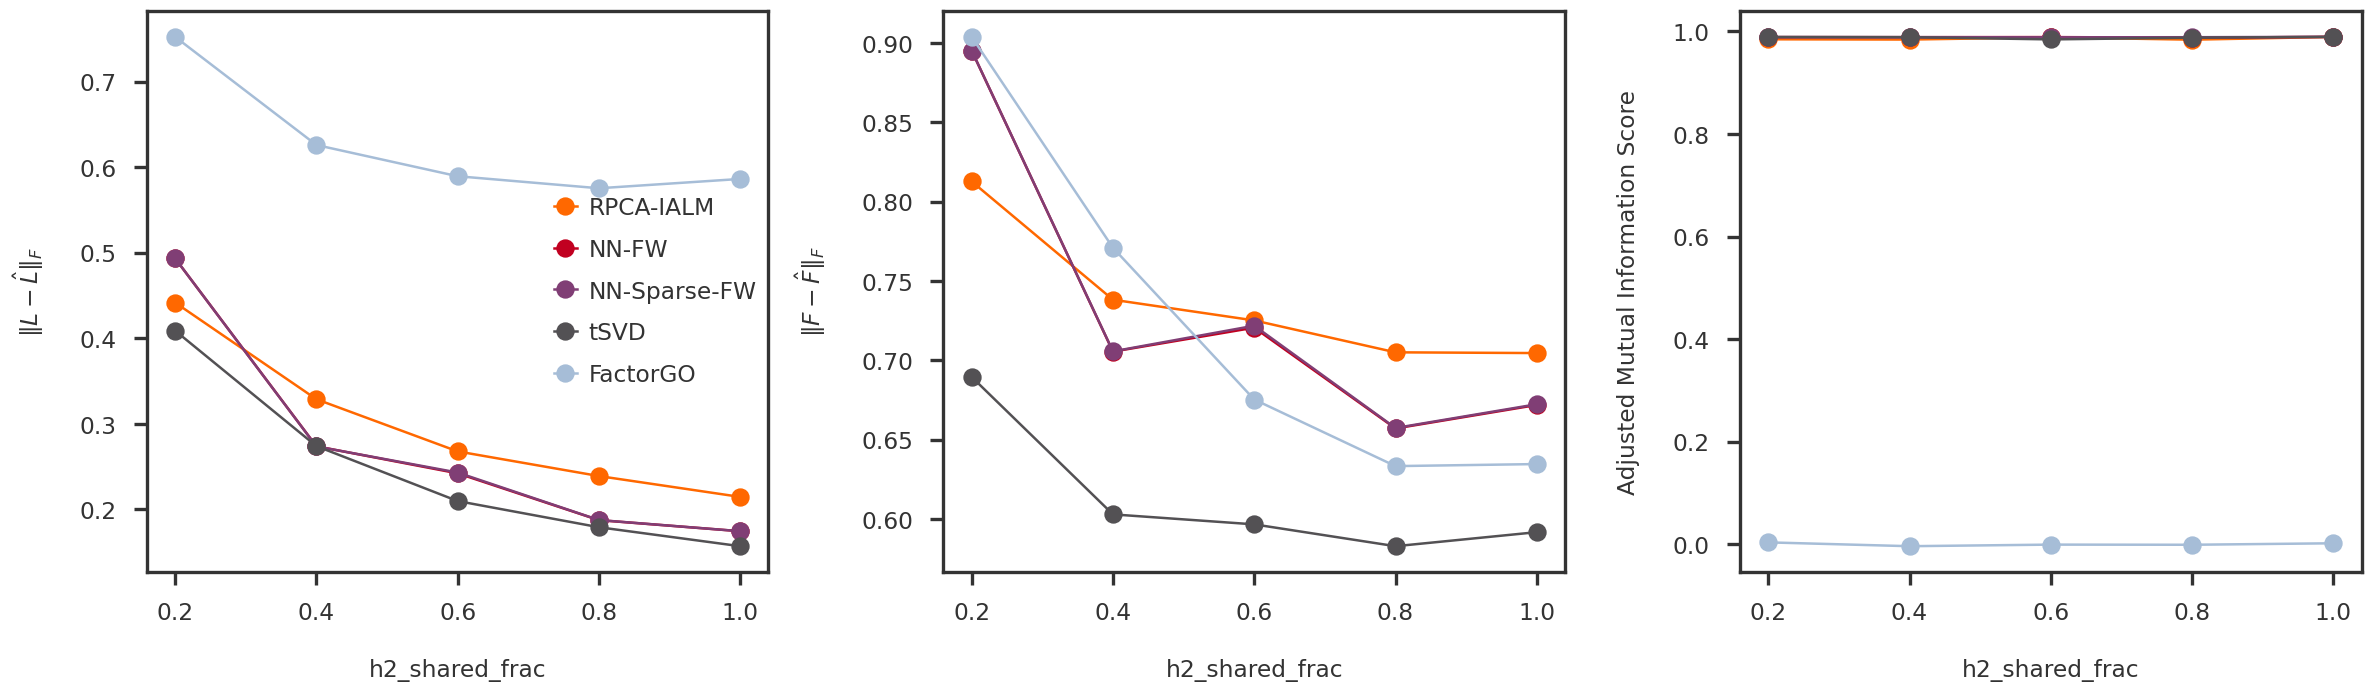

In [10]:
variable = 'h2_shared_frac'
variable_values = [0.2, 0.4, 0.6, 0.8, 1.0]
df = get_simulation_with_variable(dscout, variable, variable_values)

fig = plt.figure(figsize = (20, 6))
axs = [fig.add_subplot(1,3,x+1) for x in range(3)]
for i, (score_name, score_label) in enumerate(score_names.items()):
    scores = get_scores_from_dataframe(df, score_name, variable_values)
    for mkey in methods.keys():
        axs[i].plot(variable_values, scores[mkey], 
                    marker = 'o', markersize = 10,
                    color = method_colors[mkey], label = method_labels[mkey])
    axs[i].set_xticks(variable_values)
    axs[i].set_ylabel(score_label)
    axs[i].set_xlabel(variable)
axs[0].legend()
plt.tight_layout()
plt.show()

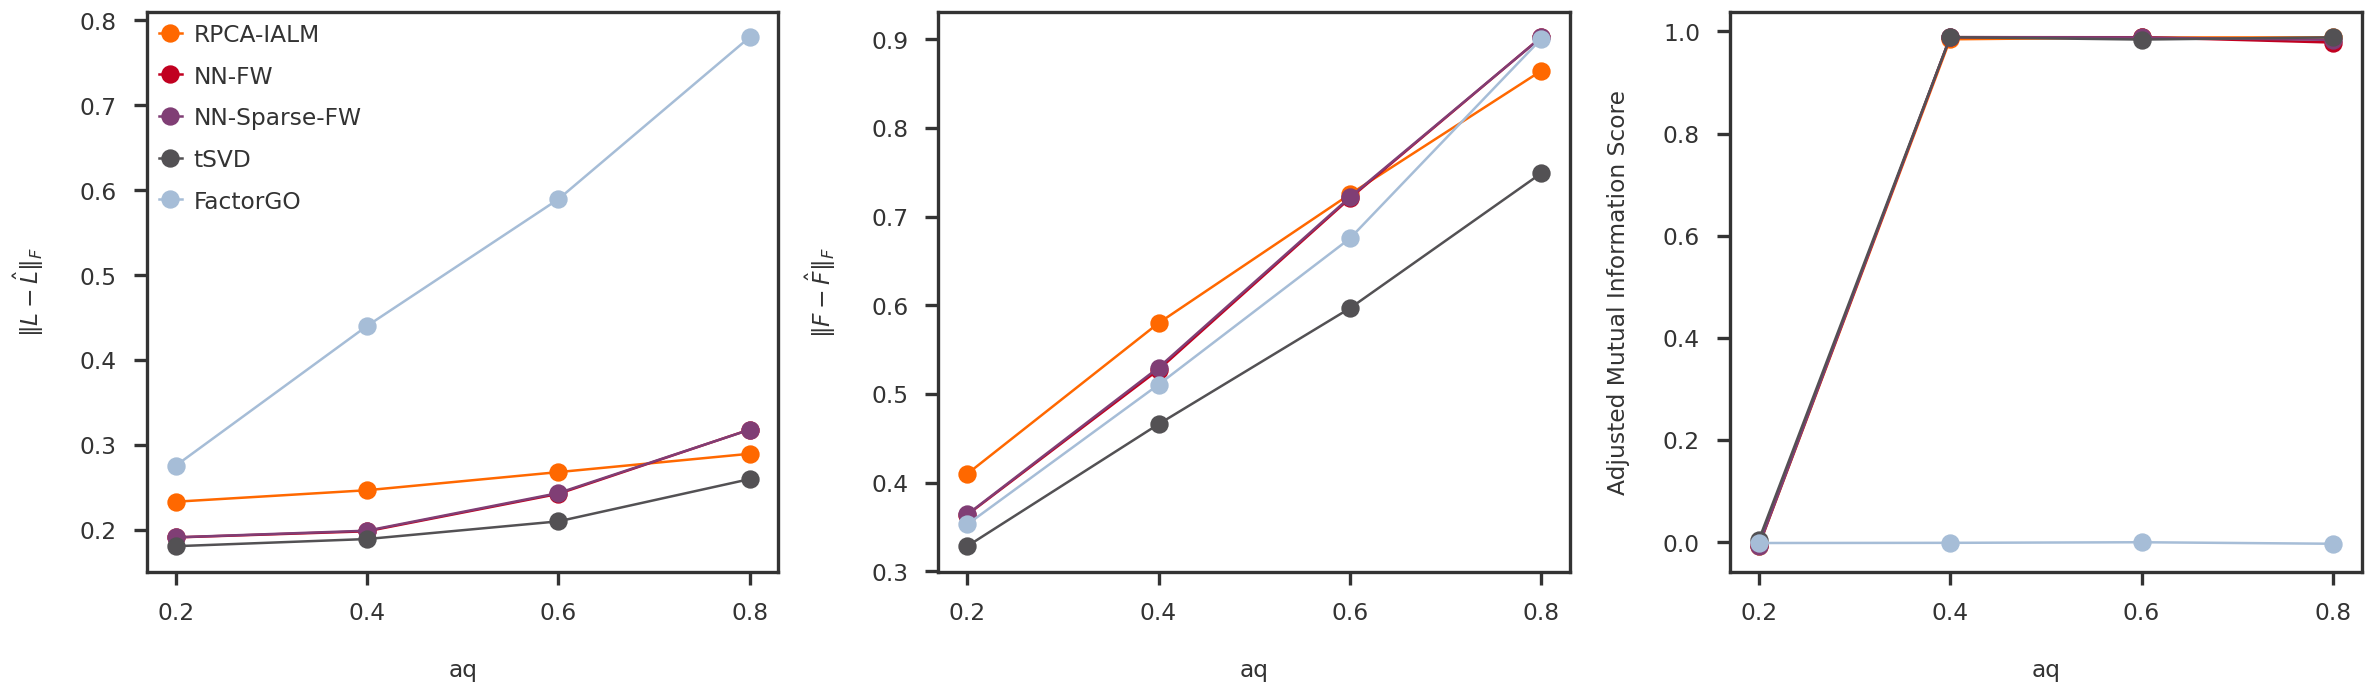

In [11]:
variable = 'aq'
variable_values = [0.2, 0.4, 0.6, 0.8]
df = get_simulation_with_variable(dscout, variable, variable_values)

fig = plt.figure(figsize = (20, 6))
axs = [fig.add_subplot(1,3,x+1) for x in range(3)]
for i, (score_name, score_label) in enumerate(score_names.items()):
    scores = get_scores_from_dataframe(df, score_name, variable_values)
    for mkey in methods.keys():
        axs[i].plot(variable_values, scores[mkey], 
                    marker = 'o', markersize = 10,
                    color = method_colors[mkey], label = method_labels[mkey])
    axs[i].set_xticks(variable_values)
    axs[i].set_ylabel(score_label)
    axs[i].set_xlabel(variable)
axs[0].legend()
plt.tight_layout()
plt.show()